<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/mit_bih_arrhythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT-BIH Arrhyhmia dataset
In this example, we will use MIT-BIH Arrhythmia dataset.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Download <code>MIT-BIH Arrhyhmia</code> dataset

In [ ]:
# If you run this code on google colab, please use this code instead of the below one.
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

In [1]:
# If you run this code on your local machine, please use this code instead of the above one.
import warnings
warnings.filterwarnings('ignore')

# Download dataset
import wget
url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
file = wget.download(url)

# Unzip
from zipfile import ZipFile
zip = ZipFile(file)
zip.extractall()

100% [........................................................................] 77030320 / 77030320

## Install <code>wfdb</code> library to read WFDB format

In [2]:
!pip install wfdb

## Visualization

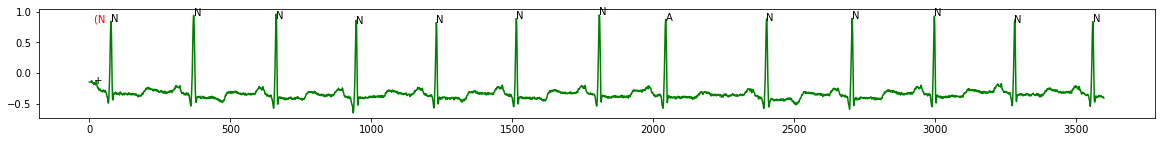

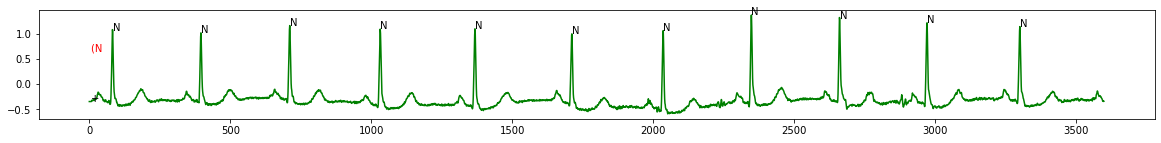

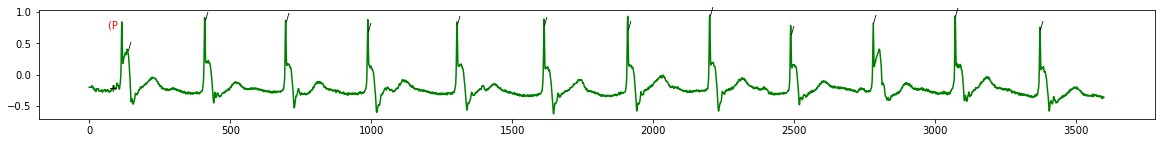

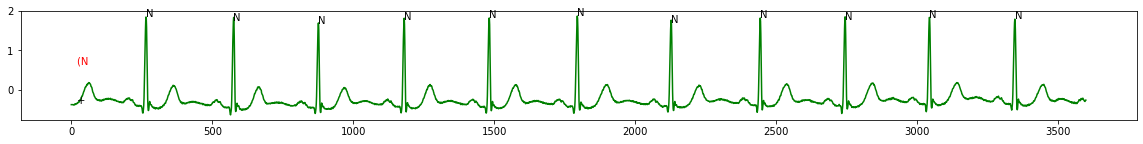

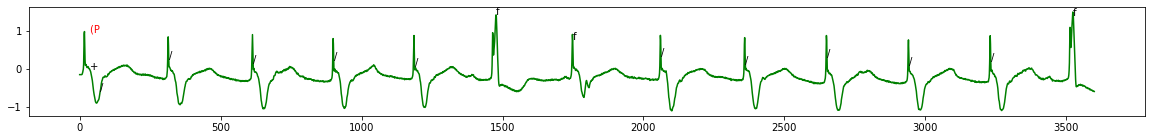

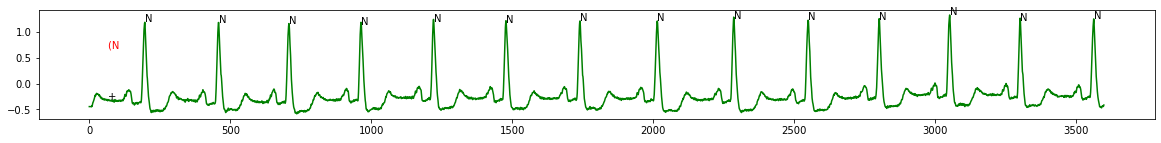

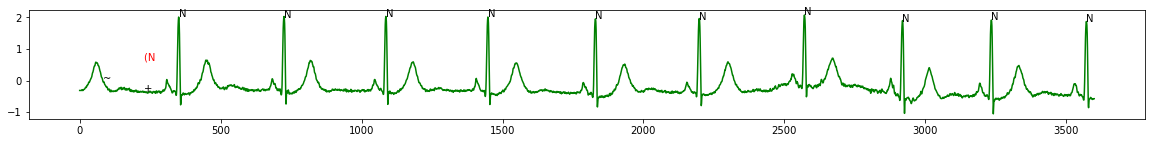

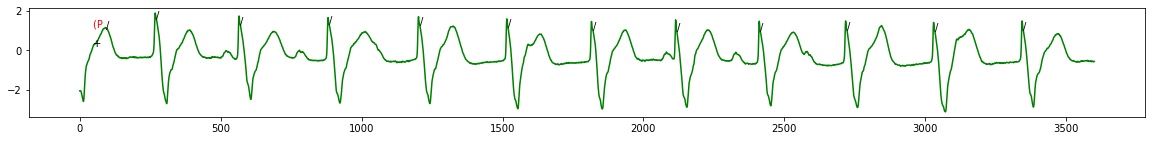

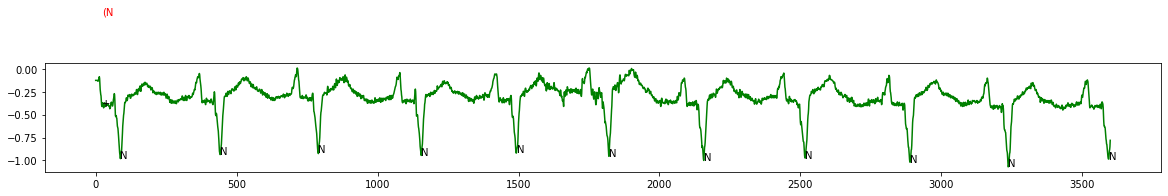

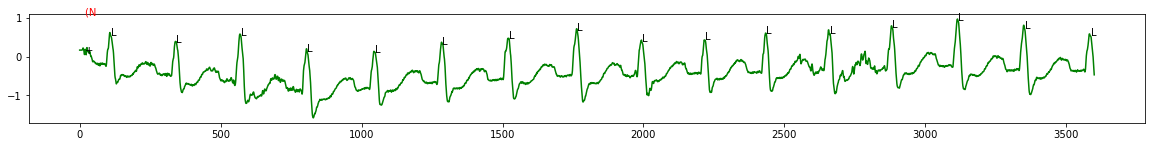

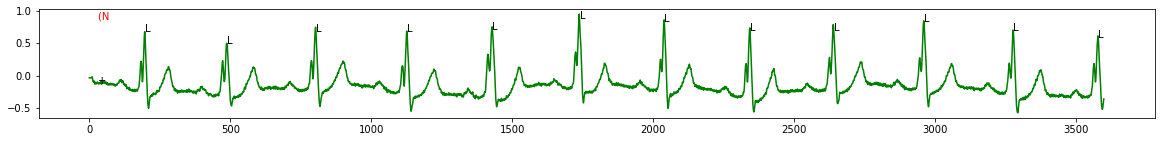

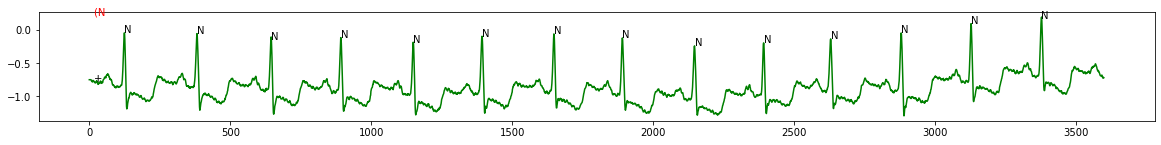

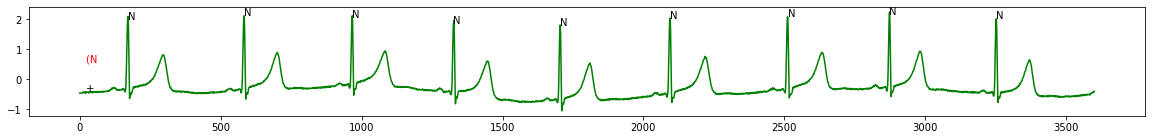

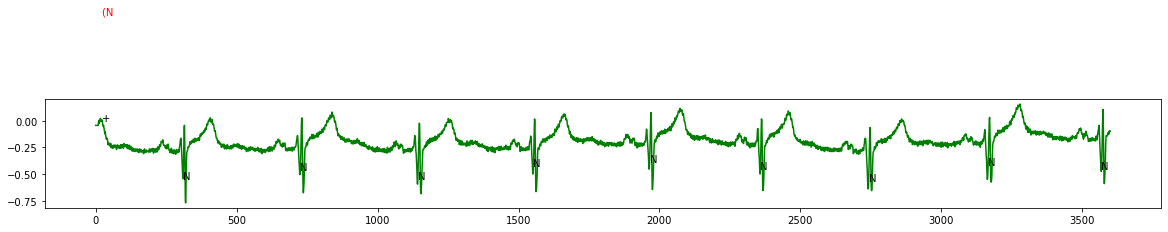

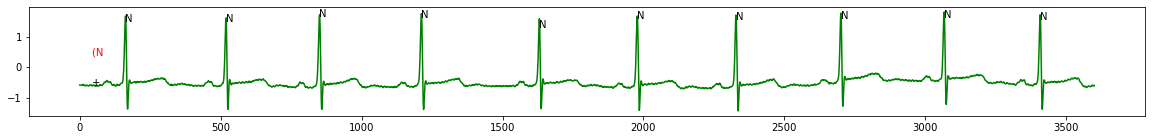

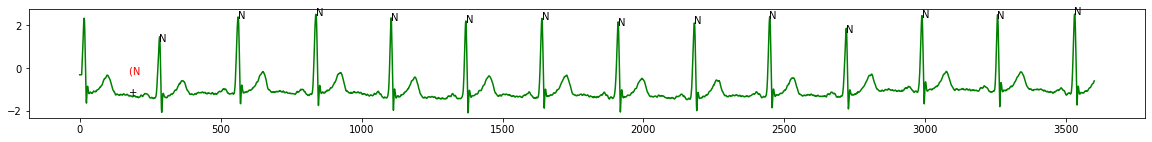

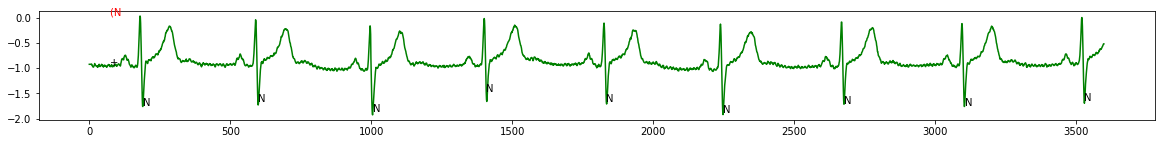

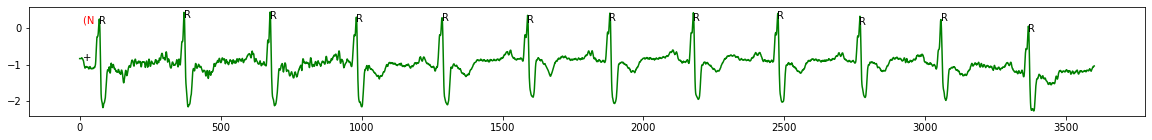

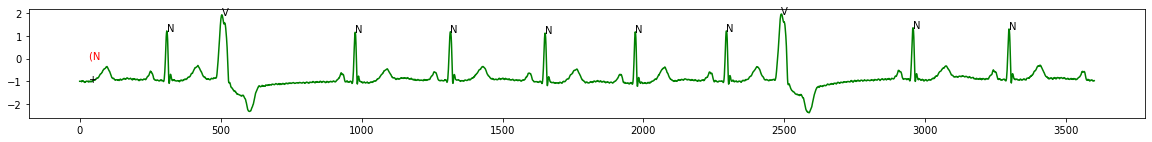

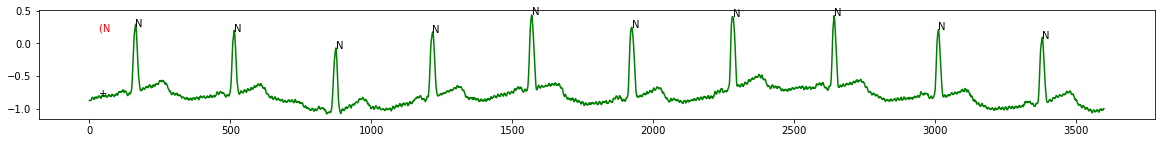

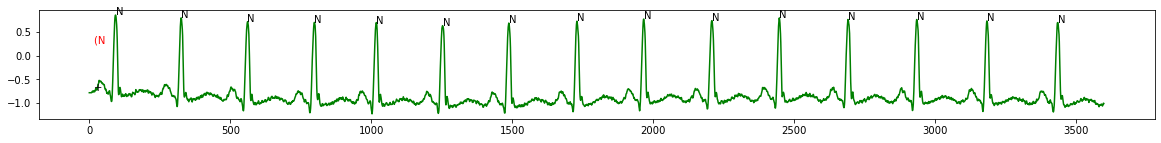

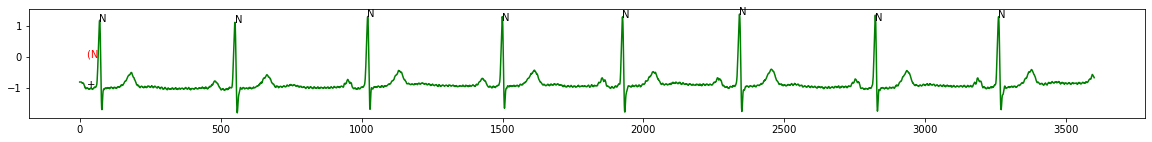

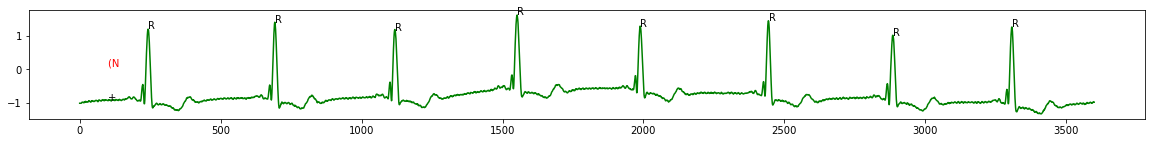

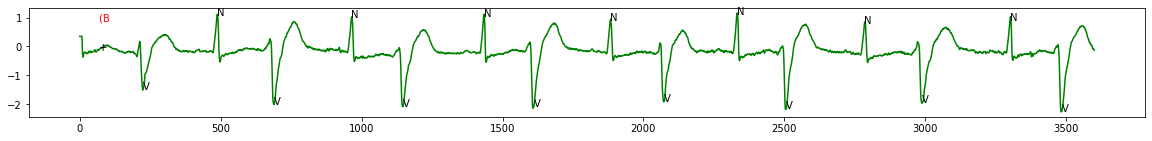

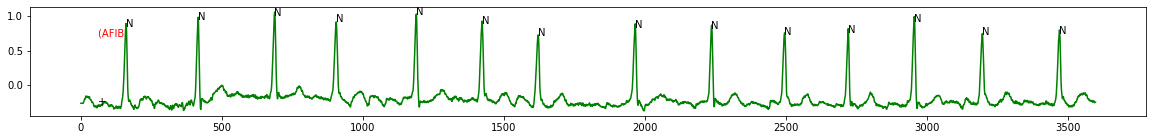

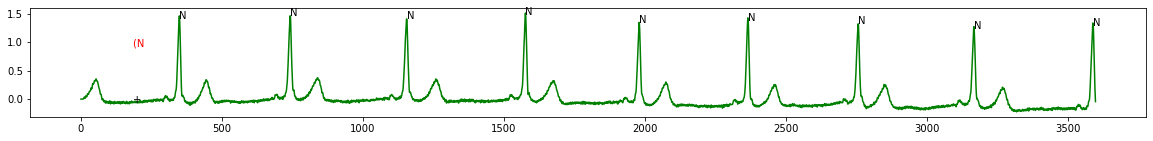

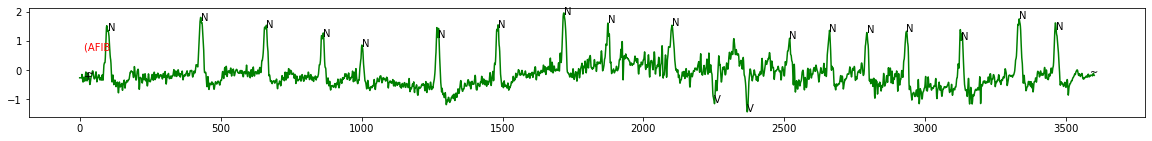

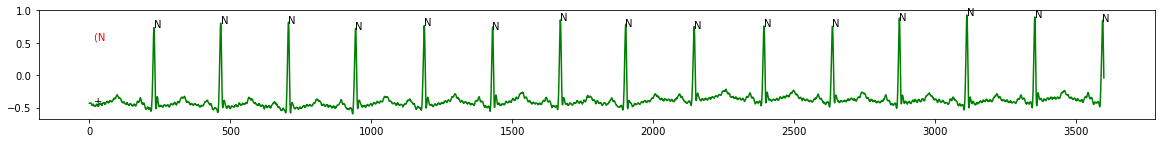

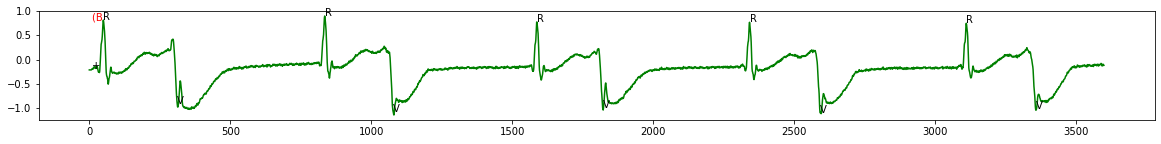

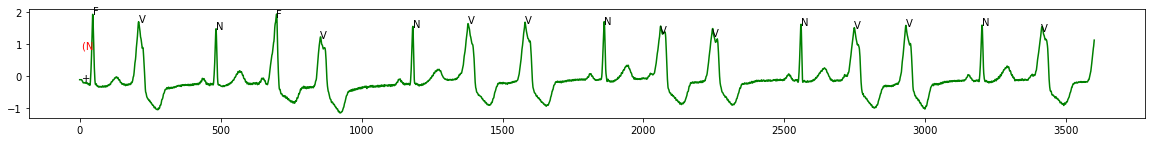

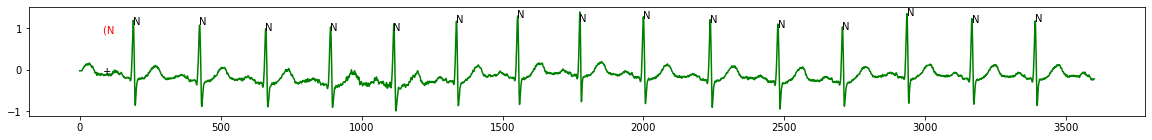

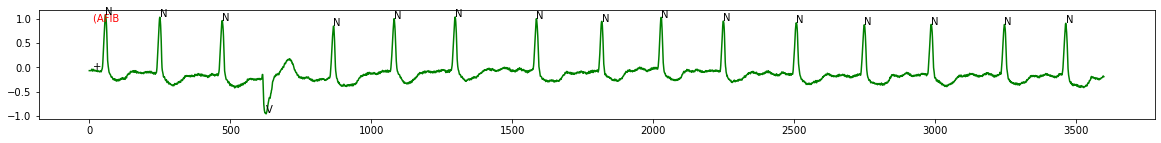

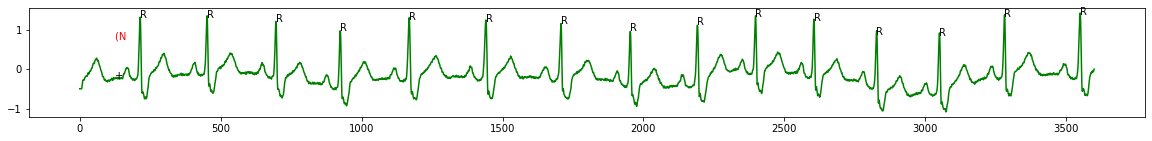

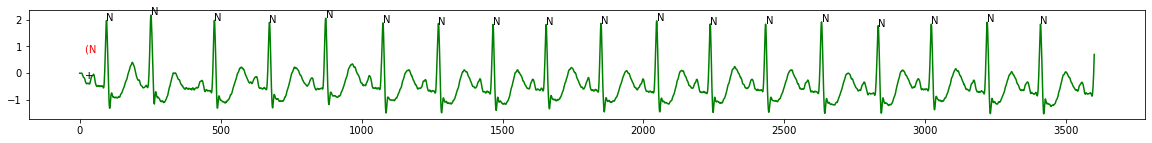

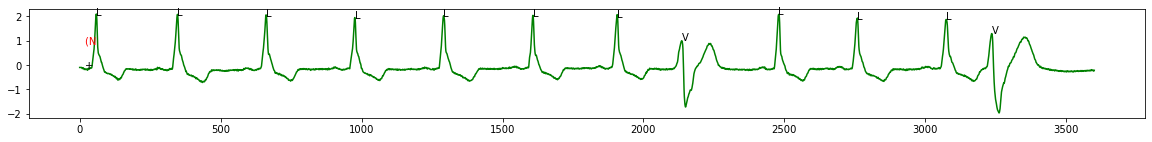

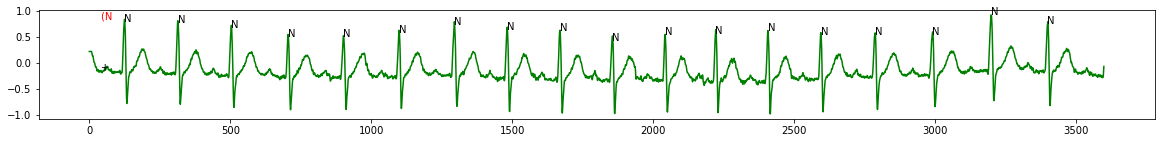

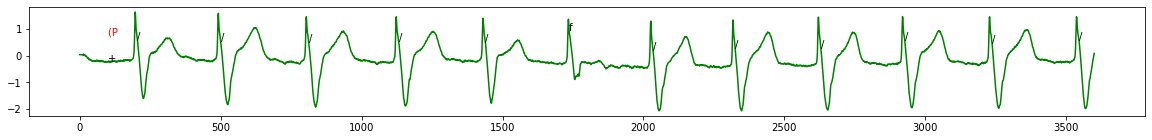

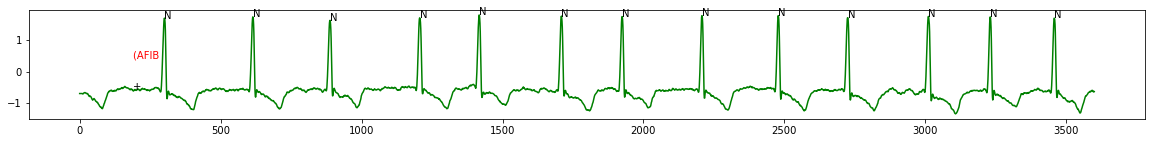

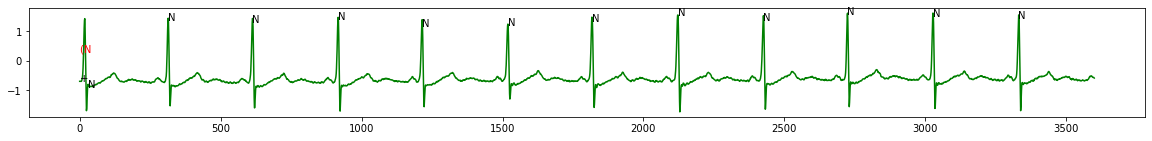

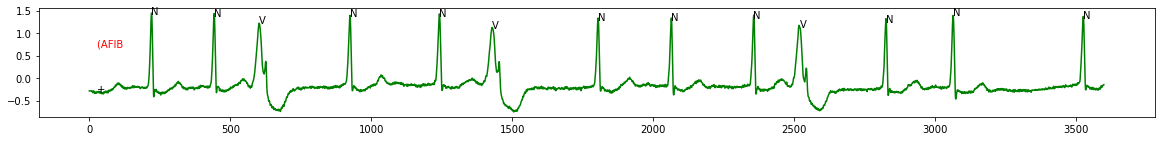

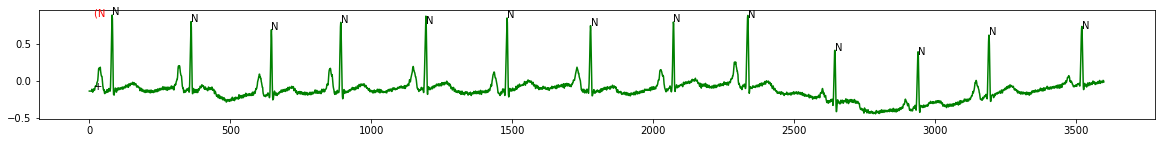

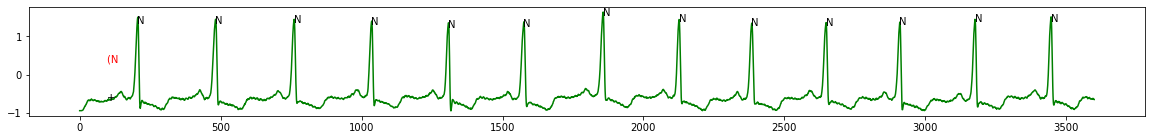

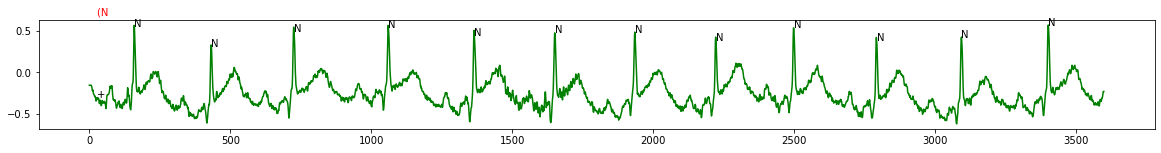

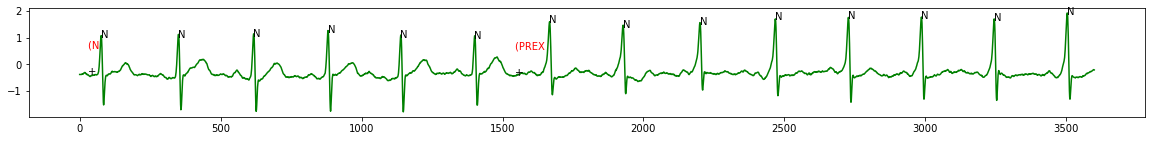

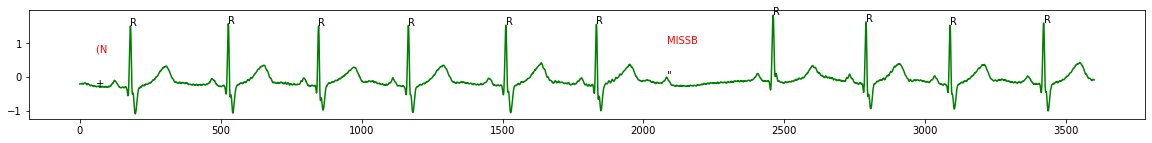

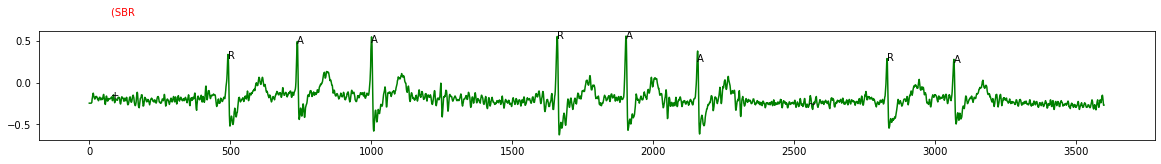

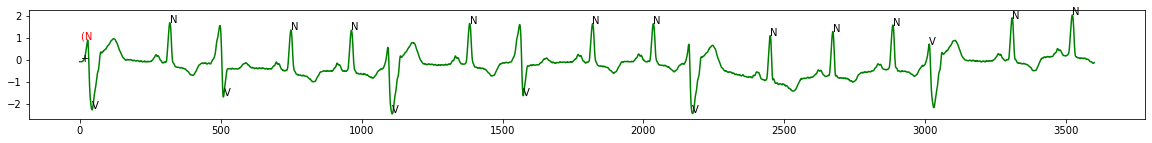

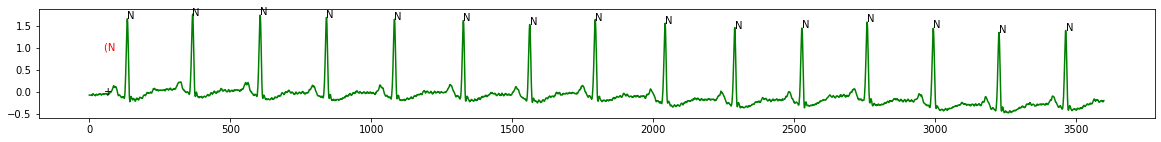

beat_type
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: count, dtype: int64
rhythm_type
         110919
(N          530
MISSB       428
(B          221
(AFIB       107
(PREX       103
(T           83
(VT          61
(P           60
(AFL         45
(NOD         36
(SVTA        26
(VFL          6
TS            6
(BII          5
(IVR          4
(AB           3
PSE           3
(SBR          1
Name: count, dtype: int64


In [3]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize dataframes to save data statistics
df_beats = pd.DataFrame()
df_rhythms = pd.DataFrame()

# Iterate files and load data
for f in os.scandir('mit-bih-arrhythmia-database-1.0.0'):
    prefix, ext = os.path.splitext(f.path)
    if ext != '.hea':  # 헤더 파일을 기준으로 case가 로딩됨
        continue

    # Load sample -> sig_name, p_signal
    samples = wfdb.rdrecord(prefix)

    # Load annotation -> symbol (beat labeling), sample, aux_note (rhythm labeling)
    labels = wfdb.rdann(prefix, 'atr')

    # Update stats
    symbols, cnts = np.unique(labels.symbol, return_counts=True)
    df_sub = pd.DataFrame({'beat_type': symbols, 'count': cnts})
    df_beats = df_beats.append(df_sub)

    symbols, cnts = np.unique(labels.aux_note, return_counts=True)
    df_sub = pd.DataFrame({'rhythm_type': symbols, 'count': cnts})
    df_rhythms = df_rhythms.append(df_sub)

    # Figure
    imax = 360 * 10
    plt.figure(figsize=(20, 2))
    plt.plot(samples.p_signal[:imax, 0], color='g')
    for i in range(len(labels.sample)):
        x = labels.sample[i]
        y = samples.p_signal[x, 0]
        if labels.chan[i] != 0:
            continue
        if x >= imax:
            continue
        beat_type = labels.symbol[i].replace('\x00',' ')
        rhythm_type = labels.aux_note[i].replace('\x00',' ')
        plt.text(x, y, beat_type)
        plt.text(x, y + 1, rhythm_type, color='r')
    plt.show()

# Print the stats
print(df_beats.groupby('beat_type')['count'].sum().sort_values(ascending=False))
print(df_rhythms.groupby('rhythm_type')['count'].sum().sort_values(ascending=False))
